In [ ]:
%matplotlib inline


# Comparing anomaly detection algorithms for outlier detection on toy datasets


This example shows characteristics of different anomaly detection algorithms
on 2D datasets. Datasets contain one or two modes (regions of high density)
to illustrate the ability of algorithms to cope with multimodal data.

For each dataset, 15% of samples are generated as random uniform noise. This
proportion is the value given to the nu parameter of the OneClassSVM and the
contamination parameter of the other outlier detection algorithms.
Decision boundaries between inliers and outliers are displayed in black
except for Local Outlier Factor (LOF) as it has no predict method to be applied
on new data when it is used for outlier detection.

The :class:`sklearn.svm.OneClassSVM` is known to be sensitive to outliers and
thus does not perform very well for outlier detection. This estimator is best
suited for novelty detection when the training set is not contaminated by
outliers. That said, outlier detection in high-dimension, or without any
assumptions on the distribution of the inlying data is very challenging, and a
One-class SVM might give useful results in these situations depending on the
value of its hyperparameters.

:class:`sklearn.covariance.EllipticEnvelope` assumes the data is Gaussian and
learns an ellipse. It thus degrades when the data is not unimodal. Notice
however that this estimator is robust to outliers.

:class:`sklearn.ensemble.IsolationForest` and
:class:`sklearn.neighbors.LocalOutlierFactor` seem to perform reasonably well
for multi-modal data sets. The advantage of
:class:`sklearn.neighbors.LocalOutlierFactor` over the other estimators is
shown for the third data set, where the two modes have different densities.
This advantage is explained by the local aspect of LOF, meaning that it only
compares the score of abnormality of one sample with the scores of its
neighbors.

Finally, for the last data set, it is hard to say that one sample is more
abnormal than another sample as they are uniformly distributed in a
hypercube. Except for the :class:`sklearn.svm.OneClassSVM` which overfits a
little, all estimators present decent solutions for this situation. In such a
case, it would be wise to look more closely at the scores of abnormality of
the samples as a good estimator should assign similar scores to all the
samples.

While these examples give some intuition about the algorithms, this
intuition might not apply to very high dimensional data.

Finally, note that parameters of the models have been here handpicked but
that in practice they need to be adjusted. In the absence of labelled data,
the problem is completely unsupervised so model selection can be a challenge.


Automatically created module for IPython interactive environment


/Users/yangqi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/yangqi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/yangqi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/yangqi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22

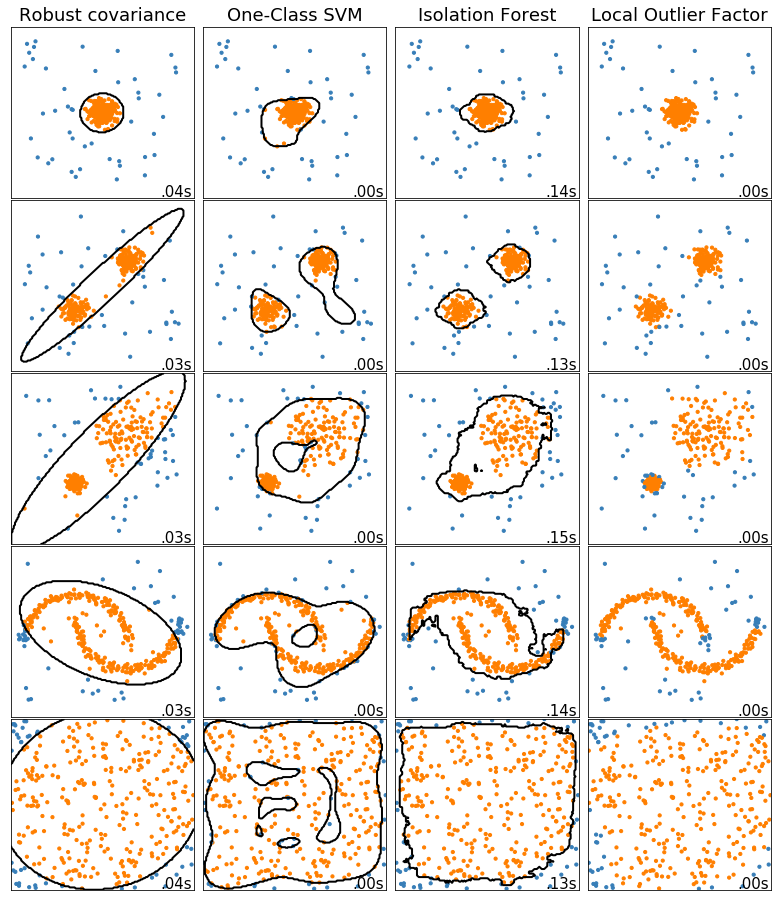

In [4]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Albert Thomas <albert.thomas@telecom-paristech.fr>
# License: BSD 3 clause

import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction))]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()